# Classification using 'video list'

In [125]:
#default_exp nb_04a

In [120]:
#export
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

In [6]:
# from fastai.utils import show_install
#show_install()

### Data

In [7]:
SOURCE = Path('../data/train_sample_videos/')

In [8]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


#### Get face detector

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
detector = MTCNN(device=device, post_process=False)

#### Remove videos in which no faces are detected.  

In [11]:
fnames = [SOURCE/o for o in annots.fname]

In [12]:
hasface = get_has_face(fnames, detector)

In [13]:
annots_hasface = annots[np.array(hasface)]

#### Create `DataBunch`

In [14]:
src = (VideoFaceList
       .from_df(df=annots_hasface, path=SOURCE, cols='fname', detector=detector)
       .split_by_rand_pct())

In [15]:
bs, sz = 32, 128

In [16]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

CPU times: user 49 s, sys: 2.54 s, total: 51.6 s
Wall time: 6.57 s


In [23]:
#%%time
#xb, yb = next(iter(data.train_dl))

CPU times: user 14.8 s, sys: 2.09 s, total: 16.9 s
Wall time: 10 s


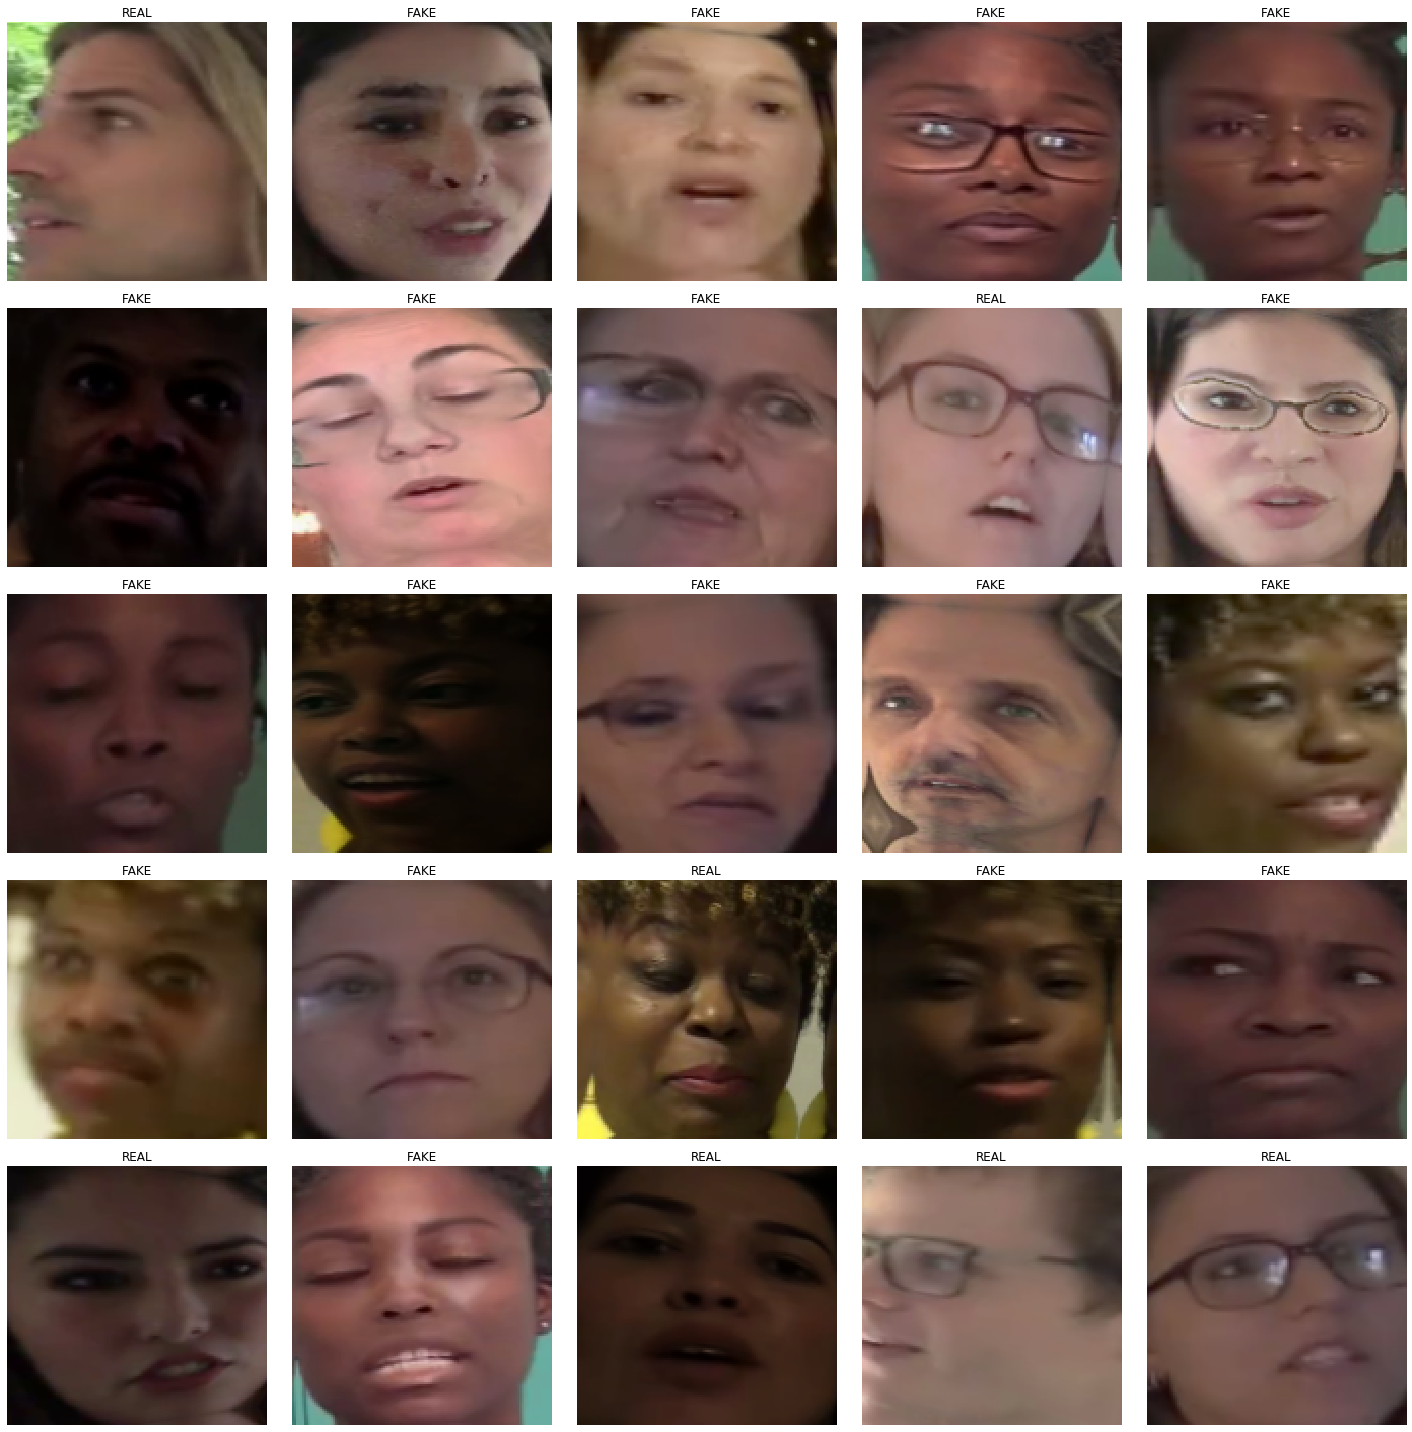

In [17]:
data.show_batch()

### Model

In [18]:
model = MesoNet()

### Learner

In [19]:
learn = Learner(data, model, metrics=accuracy)

### Train

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


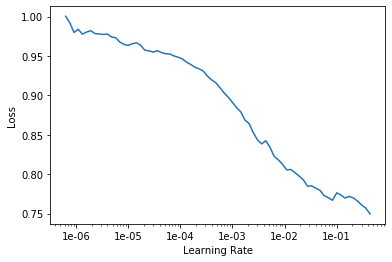

In [18]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.669727,0.633325,0.631579,01:12
1,0.632470,1.068947,0.631579,01:14
2,0.612675,0.769040,0.763158,01:13
3,0.605398,0.504144,0.842105,01:12
4,0.594712,0.466242,0.842105,01:13


In [21]:
learn.save('mesonet_stage1')

In [25]:
learn.load('mesonet_stage1');

In [26]:
learn.export('mesonet_stage1.pkl')

### Results

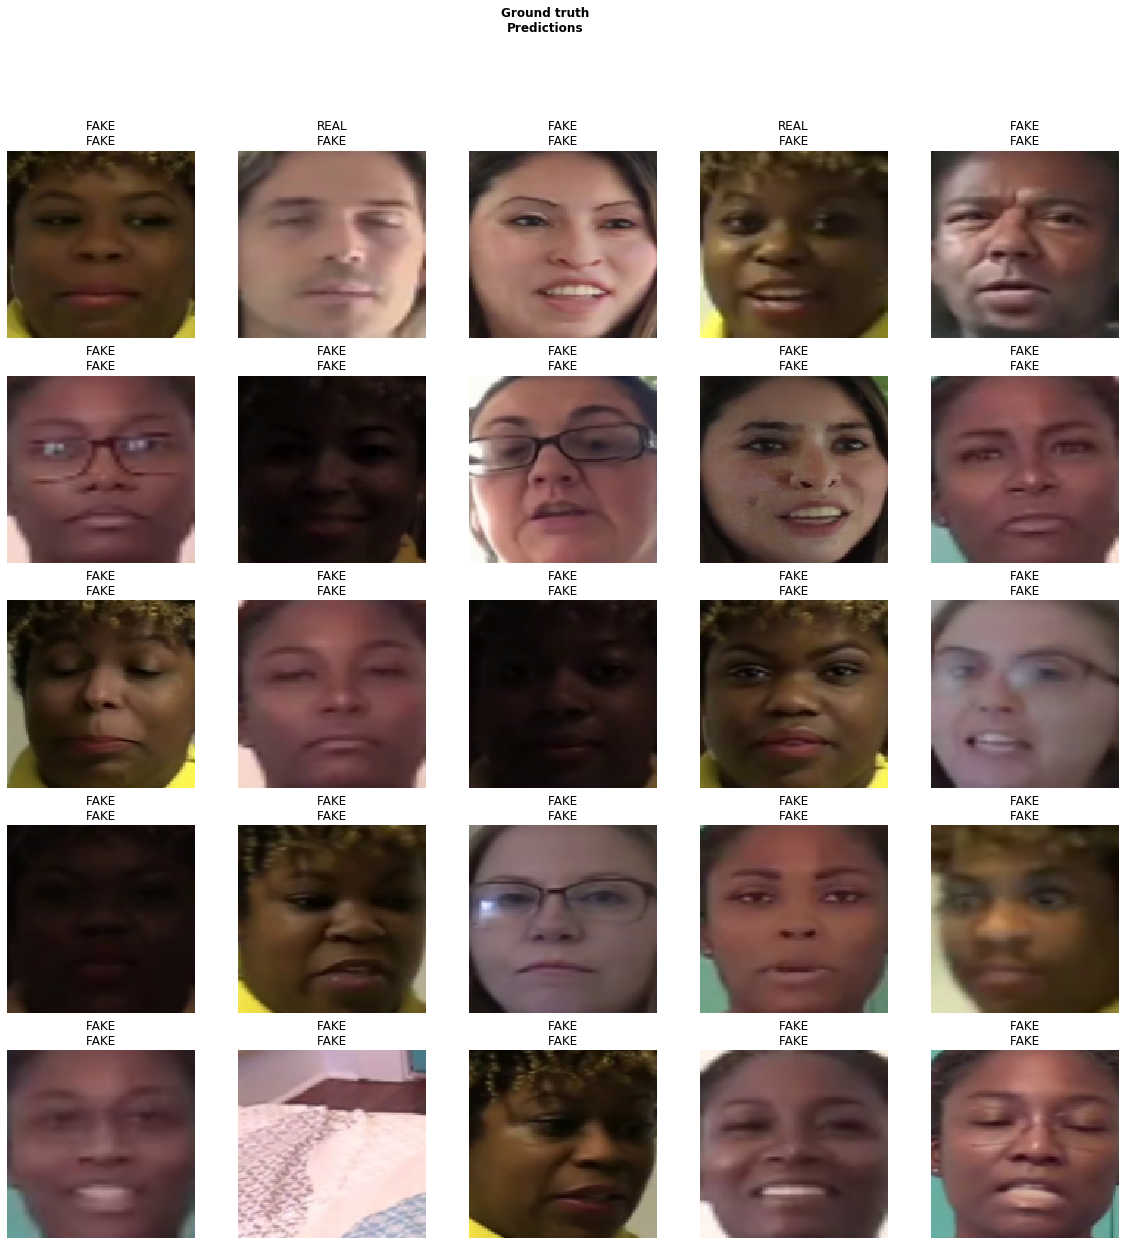

In [27]:
learn.show_results()

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

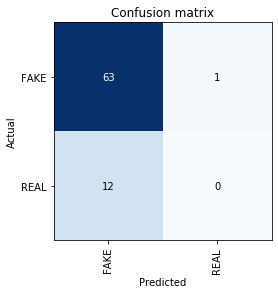

In [29]:
interp.plot_confusion_matrix()

### Inference

In [30]:
SOURCE_TEST = Path('../data/test_videos/')

In [31]:
fnames = get_files(SOURCE_TEST, extensions=['.mp4'])
fnames[:3]

[PosixPath('../data/test_videos/ihglzxzroo.mp4'),
 PosixPath('../data/test_videos/hnfwagcxdf.mp4'),
 PosixPath('../data/test_videos/ypbtpunjvm.mp4')]

Again, because we can't deal with videos which have no detected face, we need to ignore them for now.

In [32]:
hasface_tst = get_has_face(fnames, detector)

In [35]:
fnames_tst_hasface = [f for f, b in zip(fnames, hasface_tst) if b]
len(fnames_tst_hasface)

396

In [85]:
vlist = VideoFaceList(sorted(fnames_tst_hasface), detector=detector)

In [86]:
learn = load_learner(path='./', file='mesonet_stage1.pkl')

In [87]:
len(vlist_tst.items), len(vlist_tst)

(396, 396)

Note that there are 400 test videos, but we will only be able to write an entry in the submission file for 396 of these.

In [88]:
! head  ../data/sample_submission.csv

filename,label
aassnaulhq.mp4,0
aayfryxljh.mp4,0
acazlolrpz.mp4,0
adohdulfwb.mp4,0
ahjnxtiamx.mp4,0
ajiyrjfyzp.mp4,0
aktnlyqpah.mp4,0
alrtntfxtd.mp4,0
aomqqjipcp.mp4,0


In [90]:
learn.data.classes

['FAKE', 'REAL']

In [95]:
cats = learn.data.classes[:]

In [123]:
#export
def infer_on_videolist(learn:Learner, vlist:VideoFaceList):
    filenames, labels = [], []
    for i in progress_bar(range(len(vlist))):
        fn, img = vlist.items[i], vlist[i]
        y, _, _ = learn.predict(img)
        filenames.append(fn.name)
        labels.append(int(y))
    return pd.DataFrame({'filename':filenames, 'label':labels})

In [115]:
df = infer_on_videolist(learn, vlist)

In [118]:
df.to_csv('submission.csv', index=False)

In [119]:
! head submission.csv

filename,label
aassnaulhq.mp4,0
aayfryxljh.mp4,0
acazlolrpz.mp4,0
adohdulfwb.mp4,0
ahjnxtiamx.mp4,0
ajiyrjfyzp.mp4,0
aktnlyqpah.mp4,0
alrtntfxtd.mp4,0
aomqqjipcp.mp4,1


# - fin

In [126]:
from nbdev.export import *
notebook2script()

Converted 00_lookatdata.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 01_face_recog.ipynb.
Converted 01a_face_extraction.ipynb.
Converted 01b_get_one_face.ipynb.
Converted 02a_create_faceimage_dataset.ipynb.
Converted 02bis_Create_Dataset-Copy1.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
Converted 04_Baseline_Classification-Copy1.ipynb.
Converted 04_Baseline_Classification.ipynb.
Converted 04_Classification.ipynb.
Converted 04a_classification_videolist.ipynb.
Converted 05_Class_Imbalance.ipynb.
Converted 06_Focal_Loss.ipynb.
Converted test_submission.ipynb.
